In [1]:
# imports
import os
import random

# Data analysis and manipulation
import numpy as np
import pandas as pd

# Data visualization
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython import display
import seaborn as sns
import plotly

# ML, DL & Modelling
# from sklearn import 
import tensorflow as tf

# **0. Loading observations from the dataset to build X_train and y_train**

In [2]:
%%time
# Loading a fraction of the dataset
# Starting with 2 observations

BASE_DIR = '/kaggle/input/google-research-identify-contrails-reduce-global-warming/train'
number_obersvations = 1000

# Building list of record_ids
record_ids = os.listdir(BASE_DIR)

# Randomly selecting 2 observations
sample_record_ids = random.sample(record_ids, number_obersvations)
sample_record_ids

CPU times: user 10 ms, sys: 12.9 ms, total: 22.9 ms
Wall time: 233 ms


['8733450457484821474',
 '3172680701923195777',
 '7523099651734939987',
 '1082480298832649742',
 '1742236375904559280',
 '8912841915900418785',
 '7393258642035664927',
 '4036758090644416388',
 '7116985565040755841',
 '883297532245175349',
 '8744008662462894460',
 '4055361009560723859',
 '2928938447915611323',
 '7810402102266369820',
 '2034363233741681132',
 '703823145579889337',
 '2168591371898442084',
 '52267661015217883',
 '5809496268244099081',
 '2962311920903342684',
 '3444600489214436950',
 '4279771161524302655',
 '4452241869987999822',
 '1032264697118653131',
 '7537083320030451040',
 '4821415327502851751',
 '7027731910987612662',
 '600602672895009582',
 '4014659474708827557',
 '5716370081693734394',
 '7260457820968426528',
 '8013524001315441050',
 '2438924597412347765',
 '2504728284792818024',
 '8554896104117224727',
 '4567565774230415854',
 '1763529461598739038',
 '5127841891445851157',
 '2300394621749789479',
 '3052427403384539629',
 '6698711293400151969',
 '990341595632024034'

In [3]:
# Looping on the record_id list to select only band_11, with 5th layer and build X_init

band_choice = 'band_11.npy'

#['band_11.npy','band_14.npy','band_15.npy']

N_TIMES_BEFORE = 4

record_array_list = []
for sample_id in sample_record_ids:
    record_band_path = os.path.join(BASE_DIR, sample_id, band_choice)
    band = np.load(open(record_band_path, 'rb'))[:,:,N_TIMES_BEFORE]
#     print(band.shape)
    band = np.expand_dims(band, axis=-1)
#     print(band.shape)
    record_array_list.append(band)

X_init = np.stack(record_array_list, axis=0)

In [4]:
# Building the y_init array
target_suffix = 'human_pixel_masks.npy'

target_array_list = []
for sample_id in sample_record_ids:
    target_path = os.path.join(BASE_DIR, sample_id, target_suffix)
    target = np.load(open(target_path, 'rb'))
#     print(target.shape) 
#     print(target.shape)
    target_array_list.append(target)

y_init = np.stack(target_array_list, axis=0).astype(float)
y_init_test = y_init[:,:,:,0]

In [5]:
# Building a np.array with record ids
sample_ids_array = np.array(sample_record_ids)

In [6]:
# Checking all shapes
print("X_init shape is:", X_init.shape)
print("y_init shape is:", y_init.shape)
print("y_init_test shape is:", y_init_test.shape)
print("sample_ids_array shape is:", sample_ids_array.shape)

X_init shape is: (1000, 256, 256, 1)
y_init shape is: (1000, 256, 256, 1)
y_init_test shape is: (1000, 256, 256)
sample_ids_array shape is: (1000,)


In [7]:
image_test = X_init[5]
y_init_image = y_init[5]

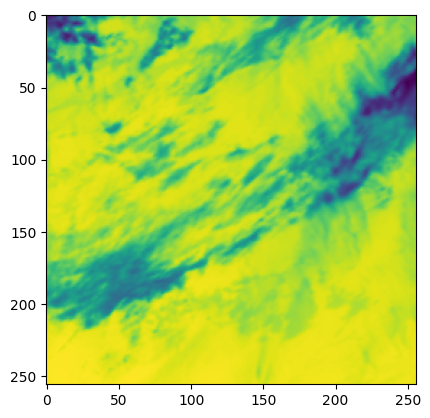

In [8]:
plt.imshow(image_test)

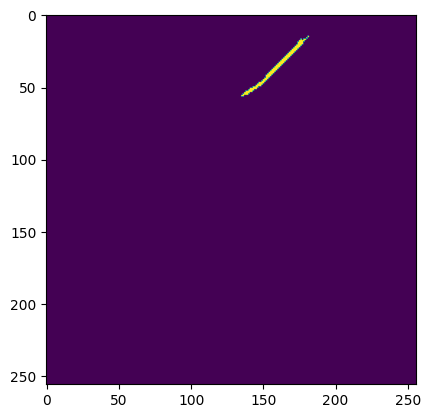

In [9]:
plt.imshow(y_init_image)

In [10]:
y_init_image.sum()

157.0

# **I. Building the dice metric for the model loss function**

In [11]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [12]:
# Defining the dice_closs as loss function used for the model 
# Generalized Dice coefficient potentially better? 

def dice_loss(y_true, y_pred):
     # Define epsilon to prevent division by zero
    epsilon = tf.keras.backend.epsilon()
    
    # Calculate the sum of y_true and y_pred for each class
    y_true_sum = tf.reduce_sum(y_true)
    y_pred_sum = tf.reduce_sum(y_pred)
    
    # Calculate the intersection and union of y_true and y_pred
    intersection = tf.reduce_sum(y_true * y_pred)
    union = y_true_sum + y_pred_sum
    
    # Calculate the Dice coefficient for each class
    dice = (2. * intersection + epsilon) / (union + epsilon)
    
    # Define the dice loss to be minimized by the model 
    dice_loss = 1 - dice
    
    return dice_loss

In [13]:
# Testing the dice loss function 

predictions_test = np.array([0.0, 1.0])
true_set = np.array([1.0, 1.0])

dice_loss(predictions_test, true_set)

<tf.Tensor: shape=(), dtype=float64, numpy=0.33333332222222256>

# II. Building a first simple CNN model 

Our first model architecture will have **2 building blocks**: 
* **Downsampling path / Decoder** = convolutional layers extracting features from the image while reducing it size
* **Upsampling / Decoder** = expanding the size of the image using Transpose convolution to reach an output (the mask) with same size as input image

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [15]:
model = Sequential()

# Encoder 
model.add(layers.Conv2D(16, (3,3), input_shape=(256, 256, 1), padding='same', activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Conv2D(32, (2,2), padding='same', activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2)))

# Decoder 
model.add(layers.Conv2DTranspose(32, (2,2), padding='same', activation="relu", strides=(2,2)))
model.add(layers.Conv2DTranspose(1, (2,2), padding='same', activation="sigmoid", strides=(2,2)))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_transpose (Conv2DTra  (None, 128, 128, 32)     4128      
 nspose)                                                         
                                                        

In [16]:
%%time
# 2. Compile
model.compile(optimizer='adam',
                  loss=dice_loss,
                  metrics="accuracy")

# 3. Fit 
from tensorflow.keras import callbacks
es = callbacks.EarlyStopping(patience=30)

history_base_model = model.fit(X_init, y_init,
          batch_size=8, # Batch size -too small--> no generalization
          epochs=10,    #            -too large--> slow computations
          validation_split=0.3,
          callbacks=[es],
          verbose=1)

Epoch 1/10
88/88 [==============================] - 26s 281ms/step - loss: 0.9889 - accuracy: 0.2576 - val_loss: 0.9886 - val_accuracy: 0.3319
Epoch 2/10
88/88 [==============================] - 24s 277ms/step - loss: 0.9888 - accuracy: 0.3622 - val_loss: 0.9885 - val_accuracy: 0.3481
Epoch 3/10
88/88 [==============================] - 24s 268ms/step - loss: 0.9889 - accuracy: 0.5842 - val_loss: 0.9886 - val_accuracy: 0.5811
Epoch 4/10
88/88 [==============================] - 24s 274ms/step - loss: 0.9888 - accuracy: 0.4665 - val_loss: 0.9885 - val_accuracy: 0.3030
Epoch 5/10
88/88 [==============================] - 24s 272ms/step - loss: 0.9887 - accuracy: 0.3186 - val_loss: 0.9885 - val_accuracy: 0.2910
Epoch 6/10
88/88 [==============================] - 24s 275ms/step - loss: 0.9887 - accuracy: 0.3535 - val_loss: 0.9885 - val_accuracy: 0.2920
Epoch 7/10
88/88 [==============================] - 24s 270ms/step - loss: 0.9886 - accuracy: 0.3446 - val_loss: 0.9884 - val_accuracy: 0.2987

In [17]:
history_base_model.__dict__

{'validation_data': None,
 'model': <keras.engine.sequential.Sequential at 0x793cef4bb370>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [0.9889006018638611,
   0.9887735247612,
   0.9889016151428223,
   0.988788366317749,
   0.9887169599533081,
   0.9887052774429321,
   0.9886428117752075,
   0.9886881709098816,
   0.9886776208877563,
   0.9886636137962341],
  'accuracy': [0.2575814723968506,
   0.3621958792209625,
   0.584183931350708,
   0.4664818346500397,
   0.31860262155532837,
   0.35346078872680664,
   0.3445974290370941,
   0.3236211836338043,
   0.2987562119960785,
   0.37316104769706726],
  'val_loss': [0.9885762333869934,
   0.9884750247001648,
   0.9885740280151367,
   0.9884737133979797,
   0.9884617328643799,
   0.9884546995162964,
   0.9884040355682373,
   0.9884243011474609,
   0.9884180426597595,
   0.9884068965911865],
  'val_accuracy': [0.33189189434051514,
   0.3481317162513733,
   0.5810713768005371,
   0.3029847741127014,
   0.29

In [18]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

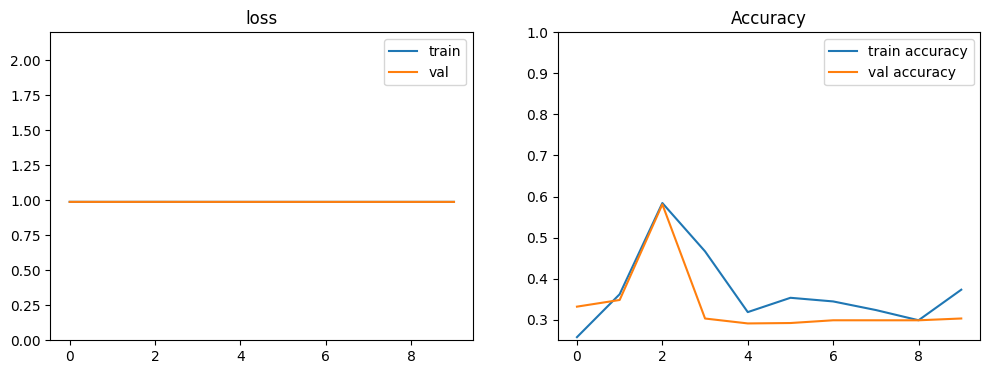

In [19]:
plot_history(history_base_model)
plt.show()

# III. Building an advanced Unet model

In [20]:
# 1. Building the Unet model 

def build_model(input_layer, start_neurons):
    
    # Downsampling path / Decoder = convolutional layers extracting features from the image while 
    # reducing it size
    conv1 = layers.Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = layers.Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)
    pool1 = layers.Dropout(0.25)(pool1)

    conv2 = layers.Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = layers.Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)
    pool2 = layers.Dropout(0.5)(pool2)

    conv3 = layers.Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = layers.Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)
    pool3 = layers.Dropout(0.5)(pool3)

    conv4 = layers.Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = layers.Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = layers.MaxPooling2D((2, 2))(conv4)
    pool4 = layers.Dropout(0.5)(pool4)

    # Middle path / Bottleneck = CNN with large number of layers to extract the image's most important /
    # complex features
    convm = layers.Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = layers.Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)
    
    # Upsampling / Decoder using Transpose convolution = expanding the size of the image to reach an output 
    # (the mask) with same size as input image 
    
    # Skip connections: it helps the model learn both detailed information from the 
    # downsampling / decoder and high-level info from the upsampling / decoder 
    
    # In practice, after the transposed convolution, the image is upsized from 28x28x1024 → 56x56x512
    # this image is then concatenated with the corresponding image from the downsampling path 
    # and together makes an image of size 56x56x1024. 
    
    # upsamppling 
    deconv4 = layers.Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    # skip-connection
    uconv4 = layers.concatenate([deconv4, conv4])
    uconv4 = layers.Dropout(0.5)(uconv4)
    uconv4 = layers.Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = layers.Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = layers.Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = layers.concatenate([deconv3, conv3])
    uconv3 = layers.Dropout(0.5)(uconv3)
    uconv3 = layers.Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = layers.Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = layers.Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = layers.concatenate([deconv2, conv2])
    uconv2 = layers.Dropout(0.5)(uconv2)
    uconv2 = layers.Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = layers.Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = layers.Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = layers.concatenate([deconv1, conv1])
    uconv1 = layers.Dropout(0.5)(uconv1)
    uconv1 = layers.Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = layers.Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    
    output_layer = layers.Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

In [21]:
# Defining img_size and number of neurons for the CNN layers 

img_size_target = 256
number_channels_target = 1
start_neurons = 16

input_layer = layers.Input((img_size_target, img_size_target, number_channels_target))
output_layer = build_model(input_layer, start_neurons)

In [22]:
# unet model with Keras Functional API
unet_model = tf.keras.Model(input_layer, output_layer, name="U-Net")

In [23]:
%%time 
# 2. Compile
unet_model.compile(optimizer='adam',
                  loss=dice_loss,
                  metrics="accuracy")

# 3. Fit 
from tensorflow.keras import callbacks
es = callbacks.EarlyStopping(patience=30)

history_unet_model = unet_model.fit(X_init, y_init,
          batch_size=8, # Batch size -too small--> no generalization
          epochs=10,    #            -too large--> slow computations
          validation_split=0.3,
          callbacks=[es],
          verbose=1)

Epoch 1/10
88/88 [==============================] - 355s 4s/step - loss: 0.9893 - accuracy: 0.4381 - val_loss: 0.9889 - val_accuracy: 0.7453
Epoch 2/10
88/88 [==============================] - 347s 4s/step - loss: 0.9951 - accuracy: 0.8242 - val_loss: 1.0000 - val_accuracy: 0.9943
Epoch 3/10
88/88 [==============================] - 349s 4s/step - loss: 0.9886 - accuracy: 0.9944 - val_loss: 1.0000 - val_accuracy: 0.9943
Epoch 4/10
88/88 [==============================] - 347s 4s/step - loss: 0.9886 - accuracy: 0.9944 - val_loss: 1.0000 - val_accuracy: 0.9943
Epoch 5/10
88/88 [==============================] - 347s 4s/step - loss: 1.0000 - accuracy: 0.9944 - val_loss: 1.0000 - val_accuracy: 0.9943
Epoch 6/10
88/88 [==============================] - 347s 4s/step - loss: 1.0000 - accuracy: 0.9944 - val_loss: 1.0000 - val_accuracy: 0.9943
Epoch 7/10
88/88 [==============================] - 351s 4s/step - loss: 1.0000 - accuracy: 0.9944 - val_loss: 1.0000 - val_accuracy: 0.9943
Epoch 8/10
88

In [24]:
history_unet_model.__dict__

{'validation_data': None,
 'model': <keras.engine.functional.Functional at 0x793ce4f8a380>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [0.9892562627792358,
   0.9951228499412537,
   0.9885677695274353,
   0.9885714054107666,
   1.0,
   1.0,
   0.9999949336051941,
   0.9885714054107666,
   1.0,
   0.9885636568069458],
  'accuracy': [0.4381222128868103,
   0.8242215514183044,
   0.9944084882736206,
   0.994408130645752,
   0.9944083094596863,
   0.9944083094596863,
   0.9944082498550415,
   0.994408369064331,
   0.9944086670875549,
   0.9944085478782654],
  'val_loss': [0.9889380931854248,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0],
  'val_accuracy': [0.7452800273895264,
   0.9942776560783386,
   0.9942776560783386,
   0.9942776560783386,
   0.9942776560783386,
   0.9942776560783386,
   0.9942776560783386,
   0.9942776560783386,
   0.9942776560783386,
   0.9942776560783386]},
 'params': {'verbose': 1, 'epochs': 10, 'steps':

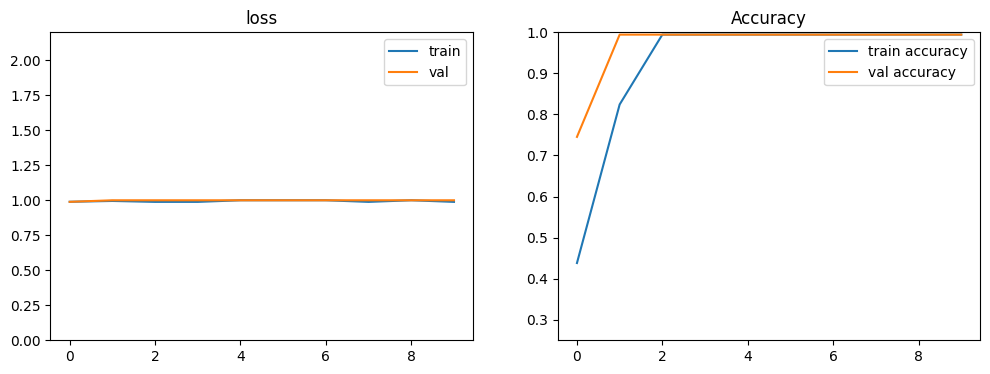

In [25]:
plot_history(history_unet_model)
plt.show()